I created a model that used location — represented by latitude and longitude — to predict price. In this project, i am going to use a different representation for location: neighborhood.

In [4]:
import warnings
import pandas as pd
import numpy as np

from glob  import glob
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from category_encoders import OneHotEncoder
from sklearn.pipeline import  Pipeline, make_pipeline

warnings.filterwarnings("ignore")

In [5]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    mask_place = df["place_with_parent_names"].str.contains("Capital Federal")
    
    mask_apt = df["property_type"] == "apartment"
    
    mask_price = df["price_aprox_usd"] < 400_000
    
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    
    df = df[mask_place & mask_apt & mask_price & mask_area]
    
    df.drop(columns=["lat-lon"], inplace=True)
    
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    
    df.drop(columns=["place_with_parent_names"],inplace=True)
    
    return df

In the last project, i used the wrangle function to import two CSV files as DataFrames. But what if we had hundreds of CSV files to import? Wrangling them one-by-one wouldn't be an option. So let's start with a technique for reading several CSV files into a single DataFrame.

The first step is to gather the names of all the files we want to import. We can do this using pattern matching.

In [8]:
files = glob("properati-AR-2016-11-01-properties-*.csv")
files

['properati-AR-2016-11-01-properties-1.csv',
 'properati-AR-2016-11-01-properties-2.csv']

In [9]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [10]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16145 entries, 0 to 16144
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   created_on                  16145 non-null  object 
 1   operation                   16145 non-null  object 
 2   property_type               16145 non-null  object 
 3   place_name                  16145 non-null  object 
 4   geonames_id                 15554 non-null  float64
 5   lat                         15490 non-null  float64
 6   lon                         15490 non-null  float64
 7   price                       16145 non-null  float64
 8   currency                    16145 non-null  object 
 9   price_aprox_local_currency  16145 non-null  float64
 10  price_aprox_usd             16145 non-null  float64
 11  surface_total_in_m2         11626 non-null  float64
 12  surface_covered_in_m2       16145 non-null  float64
 13  price_usd_per_m2            111

,created_on,operation,property_type,place_name,geonames_id,lat,lon,price,currency,price_aprox_local_currency,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,neighborhood
0,2014-03-25,rent,apartment,Puerto Madero,3429760.0,-34.603185,-58.363520,14000.0,ARS,13961.08,...,13.153857,200.000000,NaN,NaN,NaN,http://puerto-madero.properati.com.ar/e3uq_alq...,CODIGO: ubicado en: Juana Manso 500 - Public...,Alquiler 2 ambientes - Juana Manso 500,https://thumbs-cf.properati.com/2/YKyTOjY-8MQA...,Puerto Madero
1,2014-03-25,rent,apartment,Puerto Madero,3429760.0,-34.612117,-58.362471,7000.0,USD,106136.80,...,31.818182,31.818182,NaN,NaN,NaN,http://puerto-madero.properati.com.ar/e5ei_alq...,CODIGO: 808-18349 ubicado en: Azucena Villaflo...,TORRE EL FARO,https://thumbs-cf.properati.com/8/RPsd3o247OvN...,Puerto Madero
2,2014-03-25,rent,apartment,Caballito,3435874.0,-34.622564,-58.434761,3700.0,ARS,3689.61,...,4.055667,64.912281,NaN,NaN,NaN,http://caballito.properati.com.ar/e5fa_alquile...,CODIGO: 612-001 ubicado en: José María Moreno ...,Alquiler 3 ambientes Caballito,https://thumbs-cf.properati.com/9/avEDq3bj9Tg8...,Caballito
3,2014-03-25,rent,apartment,Balvanera,6693228.0,-34.608636,-58.403405,2100.0,ARS,2094.07,...,3.069111,46.666667,NaN,NaN,NaN,http://balvanera.properati.com.ar/e6r0_alquile...,CODIGO: ubicado en: Bme. Mitre y Paso - Publ...,"Departamento en Alquiler en Balvanera, Capital...",https://thumbs-cf.properati.com/6/W9gKNn8UJ4rS...,Balvanera
4,2014-03-25,rent,apartment,Palermo,3430234.0,-34.580804,-58.412091,19000.0,ARS,18947.23,...,9.612462,146.153846,NaN,NaN,NaN,http://palermo.properati.com.ar/e77o_alquiler_...,CODIGO: 127-A 34 ubicado en: Palacio Los Patos...,"Departamento en Alquiler en Palermo, Capital F...",https://thumbs-cf.properati.com/5/YqrVJA3MF3vi...,Palermo


In [9]:
len(df["neighborhood"])

16145

### Split

Creating the feature matrix X_train and target vector y_train. X_train should contain one feature: "neighborhood". Your target is "price_aprox_usd".

In [10]:
target = "price_aprox_usd"
features = ["neighborhood"]

y = df[target]
X = df[features]

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16145 entries, 0 to 16144
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   neighborhood  16145 non-null  object
dtypes: object(1)
memory usage: 126.3+ KB


### Build Model

### Baseline

Let's also condense the code we use to establish our baseline.

In [12]:
y_mean = y.mean()
y_pred_baseline = [y_mean] * len(y)
mae_baseline = mean_absolute_error(y, y_pred_baseline)
print("mean neighborhood price:", y_mean.round(2))
print("baseline mae:", mae_baseline.round(2))

mean neighborhood price: 134984.9
baseline mae: 66154.97


### Iterate

First, instantiate a OneHotEncoder named ohe. Make sure to set the use_cat_names argument to True. Next, fit your transformer to the feature matrix X_train. Finally, use your encoder to transform the feature matrix X_train, and assign the transformed data to the variable XT_train.

In [13]:
ohe = OneHotEncoder(use_cat_names=True)

ohe.fit(X)

XT_train = ohe.transform(X)
print(XT_train.shape)
XT_train.head()

(16145, 58)


,neighborhood_Puerto Madero,neighborhood_Caballito,neighborhood_Balvanera,neighborhood_Palermo,neighborhood_Villa Urquiza,neighborhood_Villa Pueyrredón,neighborhood_Barrio Norte,neighborhood_Paternal,neighborhood_Liniers,neighborhood_San Nicolás,...,neighborhood_Parque Chacabuco,neighborhood_Velez Sarsfield,neighborhood_Agronomía,neighborhood_Mataderos,neighborhood_Pompeya,neighborhood_Monte Castro,neighborhood_Villa Real,neighborhood_Parque Avellaneda,neighborhood_Villa Soldati,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Creating a pipeline named model that contains a OneHotEncoder transformer and a LinearRegression predictor. Then fit the model to the training data.

In [14]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
).fit(X,y)
model

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

### Evaluate

Regardless of how i build the model, the evaluation step stays the same. Let's see how our model performs with the training set.

In [15]:
y_pred_train = model.predict(X)
mae_training = mean_absolute_error(y, y_pred_train)
print("y_pred_train:", y_pred_train[:5])
print("mae_training:", mae_training.round(2))

y_pred_train: [ 88522.43723418  88522.43723418 147831.68693893 117937.65538908
 148697.8508549 ]
mae_training: 62799.16


### Communicate Result

Extract the intercept and coefficients for your model.

In [16]:
intercept = model.named_steps["ridge"].intercept_
coefficient = model.named_steps["ridge"].coef_
print("intercept:", intercept.round(2))
print("coefficient:", coefficient[:5].round(2))

intercept: 115282.94
coefficient: [-26760.5   32548.75   2654.72  33414.91  18621.18]


i have the values of the coefficients, but how do i know which features they belong to? We'll need to get that information by going into the part of our pipeline that did the encoding.

 Extract the feature names of the encoded data from the OneHotEncoder in the model.

In [17]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print(feature_names[:5])

['neighborhood_Puerto Madero' 'neighborhood_Caballito'
 'neighborhood_Balvanera' 'neighborhood_Palermo'
 'neighborhood_Villa Urquiza']


C:\Users\Gbest\AppData\Roaming\Python\Python310\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Creating a pandas Series named feat_imp where the index is your features and the values are the coefficients.

In [18]:
feat_imp = pd.Series(coefficient, feature_names)

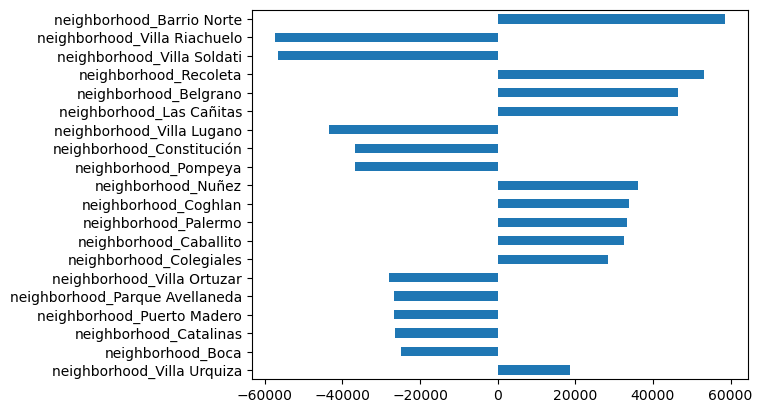

In [19]:
feat_imp.sort_values(key=abs).tail(20).plot(kind="barh");